In [39]:
# Dependencies
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import csv
from scipy.stats import linregress
from scipy import stats
import plotly.express as px

In [40]:
# Read data for 2 and 3 letter country codes that includes continent
Country_Continent_df = pd.read_csv('Data/Country-Continent.csv')
Country_Continent_df.drop(['Country_Name','Country_Number'],axis=1,inplace=True)

# Read in birthrate, deathrate, net migration, pop growth rate data file
# Source - https://console.cloud.google.com/bigquery?project=halogen-rampart-291613&pli=1&j=bq:US:bquxjob_71e8cca8_17529db0366&page=queryresults
birth_rate_df = pd.read_csv('Data/BirthRates.csv')

# Calling DataFrame constructor and creating the dataframe
column_names = ["a", "b", "c", "d", "e", "f"]
gdp_raw_df = pd.DataFrame(columns = column_names)
  
# read cvs file into already created DF
#Source - https://www.kaggle.com/theworldbank/world-bank-gdp-ranking?select=gdp-ppp-csv-.csv
with open('Data/gdp-ppp-2017.csv') as csvfile:
    readCSV = csv.reader(csvfile, delimiter=',')
    for row in readCSV:
        a_series = pd.Series(row, index = gdp_raw_df.columns)
        gdp_raw_df = gdp_raw_df.append(a_series, ignore_index=True)
Country_Continent_df
birth_rate_df       

,country_code,country_name,year,crude_birth_rate,crude_death_rate,net_migration,rate_natural_increase,growth_rate
0,SY,Syria,2017,21.22,4.00,61.46,1.722,7.869
1,VI,"Virgin Islands, British",2017,11.05,5.11,16.51,0.594,2.245
2,LU,Luxembourg,2017,11.50,7.26,15.52,0.424,1.976
3,QA,Qatar,2017,9.61,1.54,14.61,0.807,2.268
4,CJ,Cayman Islands,2017,12.01,5.77,13.83,0.624,2.007
...,...,...,...,...,...,...,...,...
223,LE,Lebanon,2017,14.27,4.95,-20.34,0.932,-1.103
224,FM,"Micronesia, Federated States of",2017,19.95,4.22,-20.89,1.573,-0.516
225,AQ,American Samoa,2017,19.59,5.90,-26.70,1.369,-1.301
226,CW,Cook Islands,2017,13.99,8.40,-33.48,0.559,-2.788


In [41]:
# Cleaning Data fromgile gdp-ppp-2017
gdp_format_df=gdp_raw_df
gdp_format_df.drop([0,1,2,3,4], axis=0,inplace=True)
gdp_format_df.reset_index(inplace=True,drop=True)
gdp_format_df['a'].replace('', np.nan, inplace=True)
gdp_format_df.dropna(subset=['a'], inplace=True)

# remove commas from column e(gpd data) and remove blank columns
gdp_format_df['e'] = gdp_format_df['e'].str.replace(',', '') 
gdp_format_df.drop(['c','f'],axis=1,inplace=True)
gdp_format_df.head()

,a,b,d,e
0,CHN,1,China,23350230
1,USA,2,United States,19485394
2,IND,3,India,9596835
3,JPN,4,Japan,5333444
4,DEU,5,Germany,4345631


In [42]:
# Getting location to split read file into two pieces
# both regional and country data contained in same columns
Index_pos = gdp_format_df.a[gdp_format_df.a == 'WLD'].index.tolist()
Index_pos2 = gdp_format_df.a[gdp_format_df.a == 'LIC'].index.tolist()
Index_pos3 = gdp_format_df.a[gdp_format_df.a == 'TUV'].index.tolist()

#Getting only Country Data into data frame
gdp_country_df = gdp_format_df.truncate(after=Index_pos3[0])
gdp_country_df['e'] = gdp_country_df['e'].astype(int)  # convert column from string to integer

#Getting only region data excluding WLD
gdp_region_df = gdp_format_df.truncate(before=Index_pos[0],after=Index_pos2[0]-1)
gdp_region_df['e'] = gdp_region_df['e'].astype(int)  # convert column from string to integer

#Restting Index back to 0
gdp_region_df.reset_index(inplace=True,drop=True)
gdp_country_df.rename(columns={'a': 'country_code', 'b': 'rank', 'd': 'country_name', 'e': 'gdp'}, inplace=True)
gdp_region_df.rename(columns={'a': 'region_code', 'b': 'rank', 'd': 'region_name', 'e': 'region_gdp'}, inplace=True)
gdp_region_df.drop([0], axis=0,inplace=True)
gdp_region_df.reset_index(inplace=True,drop=True)
gdp_region_df.head(20)

,region_code,rank,region_name,region_gdp
0,EAS,,East Asia & Pacific,41946676
1,ECS,,Europe & Central Asia,30688963
2,LCN,,Latin America & Caribbean,10258018
3,MEA,,Middle East & North Africa,8864772
4,NAC,,North America,21196625
5,SAS,,South Asia,11766663
6,SSF,,Sub-Saharan Africa,4072459


In [43]:
# Read data population file World-Pop-2017
World_pop_df = pd.read_csv('Data/World-Pop-2017.csv')
World_pop_df['Country Code'].replace('', np.nan, inplace=True)
World_pop_df.dropna(subset=['Country Code'], inplace=True)
World_pop_df.drop(['Series Name','Series Code','Country Name'], axis = 1, inplace=True)
World_pop_df.rename(columns = {'2017 [YR2017]': 'Population 2017'}, inplace=True)
World_pop_df


,Country Code,Population 2017
0,AFG,36296400
1,ALB,2873457
2,DZA,41389198
3,ASM,55620
4,AND,77001
...,...,...
254,PSE,4454805
255,WLD,7509065705
256,YEM,27834821
257,ZMB,16853688


In [44]:
# Merge Files

# Merge GDP with population to calculate per capita GDP lowest 20 countries
gdp_per_capita = pd.merge(gdp_country_df, World_pop_df, left_on = 'country_code', right_on ='Country Code', how = 'left')
gdp_per_capita['Population 2017'] = gdp_per_capita['Population 2017'].astype(int)
gdp_per_capita['per capita'] = gdp_per_capita['gdp'] / gdp_per_capita['Population 2017'] * 1000000

# Merge 4 files together, GDP, Population, Country conversion, and birthrate dataframes
gdp_birth_df = pd.merge(gdp_per_capita, Country_Continent_df, left_on = 'country_code', 
                        right_on ='Three_Letter_Country_Code', how = 'left')
gdp_birth_df = pd.merge(gdp_birth_df, birth_rate_df, left_on = 'Two_Letter_Country_Code', right_on ='country_code', how = 'left')
gdp_birth_df.drop(['country_name_y','country_code_y','Country Code', 'Three_Letter_Country_Code',
                    'Continent_Code' ],axis=1,inplace=True)
gdp_birth_df.rename(columns={'country_code_x': 'country_code', 'country_name_x': 'country_name',
                            'Two_Letter_Country_Code':'Two_Letter'}, inplace=True)
gdp_birth_df.to_csv("Data/GDP_Birthrate_Final.csv", index = False, header=True)
gdp_birth_df.dropna(subset=['year'], inplace=True)

# Remove net migration is 0 (bad data) and outliers due to war
net_migration = gdp_birth_df     # used for heat map of net migration before cleaning
gdp_birth_df = gdp_birth_df.loc[gdp_birth_df['net_migration'] != 0]
gdp_birth_df = gdp_birth_df.loc[gdp_birth_df['net_migration']>-30]
gdp_birth_df


,country_code,rank,country_name,gdp,Population 2017,per capita,Continent_Name,Two_Letter,year,crude_birth_rate,crude_death_rate,net_migration,rate_natural_increase,growth_rate
0,CHN,1,China,23350230,1386395000,16842.407827,Asia,CN,2017.0,26.08,7.24,-2.44,1.884,1.639
1,USA,2,United States,19485394,324985539,59957.726304,North America,US,2017.0,12.10,8.40,3.40,0.370,0.720
2,IND,3,India,9596835,1338658835,7168.992389,Asia,IN,2017.0,19.01,7.28,-0.04,1.173,1.169
7,BRA,7,Brazil,3255145,207833831,15662.247981,South America,BR,2017.0,14.11,6.68,-0.14,0.743,0.729
8,IDN,8,Indonesia,3249635,264645886,12279.182001,Asia,ID,2017.0,16.17,6.45,-1.14,0.972,0.858
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
187,VCT,181,St. Vincent and the Grenadines,1293,109827,11773.061269,North America,VC,2017.0,13.19,7.32,-8.36,0.587,-0.248
190,STP,184,São Tomé and Principe,686,207089,3312.585410,Africa,ST,2017.0,13.31,7.66,-2.47,0.565,0.318
192,FSM,186,"Micronesia, Fed. Sts.",391,111459,3508.016401,Oceania,FM,2017.0,19.95,4.22,-20.89,1.573,-0.516
196,NRU,190,Nauru,194,12876,15066.790929,Oceania,NR,2017.0,23.96,5.91,-12.76,1.805,0.529


In [45]:
gdp_birth_df.describe()

,gdp,Population 2017,per capita,year,crude_birth_rate,crude_death_rate,net_migration,rate_natural_increase,growth_rate
count,1.160000e+02,1.160000e+02,116.000000,116.0,116.000000,116.000000,116.000000,116.000000,116.000000
mean,8.589699e+05,5.134478e+07,23377.663457,2017.0,18.885345,7.699828,-0.571552,1.118552,1.061422
std,2.966534e+06,1.824633e+08,24478.316287,0.0,9.596917,2.582819,5.533223,0.978610,1.002163
min,4.400000e+01,1.137000e+04,737.375838,2017.0,6.560000,1.540000,-20.890000,-0.379000,-1.084000
25%,2.775450e+04,2.078094e+06,5523.171725,2017.0,11.327500,6.017500,-2.447500,0.352000,0.315250
50%,8.189950e+04,7.233824e+06,15182.785761,2017.0,16.390000,7.485000,-0.355000,1.020000,0.938500
75%,5.182888e+05,3.118985e+07,30666.632037,2017.0,23.612500,9.427500,1.535000,1.717500,1.713000
max,2.335023e+07,1.386395e+09,124609.318228,2017.0,44.240000,15.020000,15.520000,3.502000,3.524000


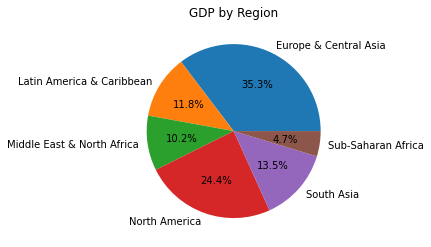

In [46]:
# Create pie graph from regions using gdp_region_df cleaned data
gdp_region = gdp_region_df.drop(0, axis = 0)
region = gdp_region['region_name']
sizes = gdp_region['region_gdp']
plt.pie(sizes, labels = region, autopct="%1.1f%%")
plt.title('GDP by Region')
plt.savefig("Output/Pie-Regions.png")
plt.show()

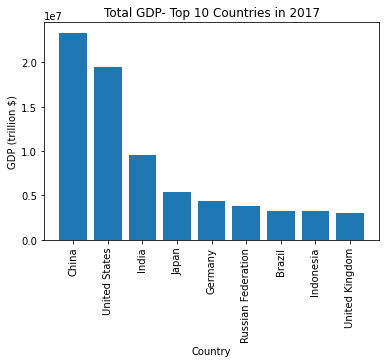

In [47]:
# bar graph of top 10 countries by total GDP
x_axis = gdp_country_df.iloc[0:9,2]
y_axis = gdp_country_df.iloc[0:9,3]
plt.bar(x_axis, y_axis)
tick_locations = [x for x in range(len(x_axis))]
plt.xticks(tick_locations, x_axis, rotation="vertical") 
plt.xlabel("Country")
plt.ylabel('GDP (trillion $)')
plt.title("Total GDP- Top 10 Countries in 2017")
plt.savefig("Output/TotalGDP-TopTen.png")
plt.show()

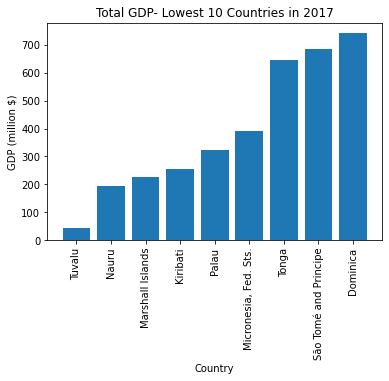

In [48]:
# bar graph of lowest 10 countries by total GDP
gdp_country_low_df =  gdp_per_capita.sort_values(by = ['gdp'], ascending = True)
x_axis_low = gdp_country_low_df.iloc[0:9,2]
y_axis_low = gdp_country_low_df.iloc[0:9,3]
plt.bar(x_axis_low , y_axis_low )
tick_locations = [x for x in range(len(x_axis_low ))]
plt.xticks(tick_locations, x_axis_low , rotation="vertical") 
plt.xlabel("Country")
plt.ylabel('GDP (million $)')
plt.title("Total GDP- Lowest 10 Countries in 2017")
plt.savefig("Output/TotalGDP-BottomTen.png")
plt.show()

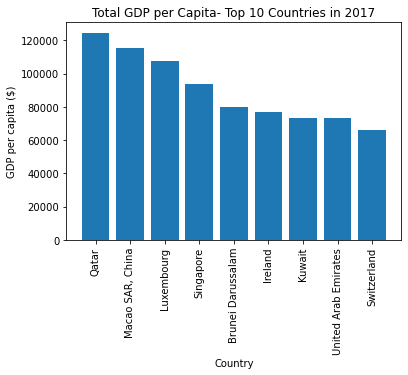

In [70]:
# Highest countries with per capita GDP bar chart
gdp_per_capita.sort_values(by = ['per capita'], ascending = False, inplace = True)
x_axis_capitamax = gdp_per_capita.iloc[0:9,2]
y_axis_capitamax = gdp_per_capita.iloc[0:9,6]
plt.bar(x_axis_capitamax, y_axis_capitamax)
tick_locations = [x for x in range(len(x_axis_capitamax))]
plt.xticks(tick_locations, x_axis_capitamax, rotation="vertical") 
plt.xlabel("Country")
plt.ylabel('GDP per capita ($)')
plt.title("Total GDP per Capita- Top 10 Countries in 2017")
plt.savefig("Output/CapitaGDP-TopTen.png")
plt.show()

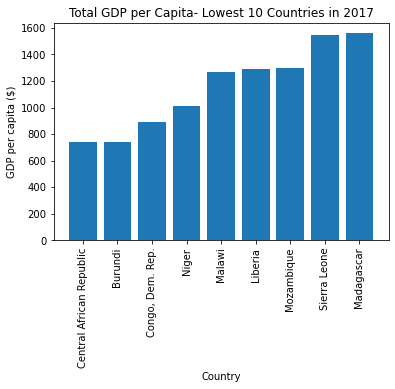

In [64]:
# Merge GDP with population to calculate per capita GDP lowest 20 countries
x_axis_gdplow = country_percap_lowest.iloc[0:9,2]
y_axis_gdplow = country_percap_lowest.iloc[0:9,6]
plt.bar(x_axis_gdplow, y_axis_gdplow)
tick_locations = [x for x in range(len(x_axis_gdplow))]
plt.xticks(tick_locations, x_axis_gdplow, rotation="vertical") 
plt.xlabel("Country")
plt.ylabel('GDP per capita ($)')
plt.title("Total GDP per Capita- Lowest 10 Countries in 2017")
plt.savefig("Output/CapitaGDP-LowestTen.png")
plt.show()


r-value -0.01


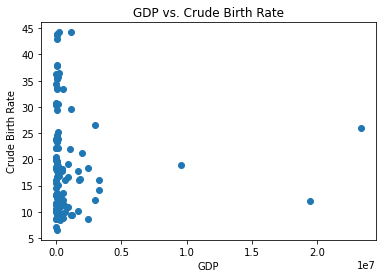

In [66]:
# GDP and Crude Brith Rate
x_gdp = gdp_birth_df['gdp']
y_birth = gdp_birth_df['crude_birth_rate']
plt.scatter(x_gdp, y_birth)
plt.xlabel('GDP')
plt.ylabel('Crude Birth Rate')
plt.title('GDP vs. Crude Birth Rate')
(slope, intercept, rvalue, pvalue, stderr) = stats.linregress(x_gdp, y_birth)

print(f"r-value {round(rvalue,2)}")
plt.show()


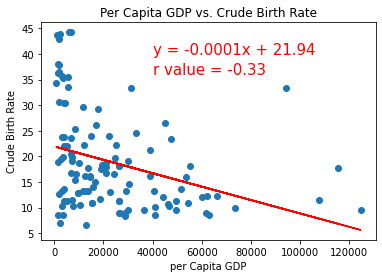

In [52]:
# Per Capita GDP verse Crude Birth Rate
x_gdp = gdp_birth_df['per capita']
y_birth = gdp_birth_df['crude_birth_rate']
plt.scatter(x_gdp,y_birth)
plt.xlabel('per Capita GDP')
plt.ylabel('Crude Birth Rate')
plt.title('Per Capita GDP vs. Crude Birth Rate')

# Linear Regression
(slope, intercept, rvalue, pvalue, stderr) = stats.linregress(x_gdp, y_birth)
regress_values = x_gdp * slope + intercept
plt.plot(x_gdp, regress_values, "r-")
reg_str = f"y = {round(slope,4)}x + {round(intercept,2)}"
plt.annotate(reg_str,(40000,40),fontsize=15,color="red")
plt.annotate(f"r value = {round(rvalue,2)}",(40000,36),fontsize=15,color="red")
plt.savefig("Output/CapitaGDP-CrudeBirthRate-Regression.png")
plt.show()


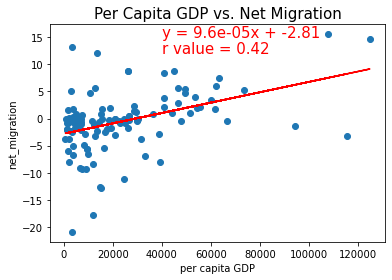

In [53]:
# Per Capita GDP verse net migration
x_gdp = gdp_birth_df['per capita']
y_migr = gdp_birth_df['net_migration']
plt.scatter(x_gdp,y_migr)
plt.xlabel('per capita GDP')
plt.ylabel('net_migration')
plt.title('Per Capita GDP vs. Net Migration',fontsize=15)

# Linear Regression
(slope, intercept, rvalue, pvalue, stderr) = stats.linregress(x_gdp, y_migr)
regress_values = x_gdp * slope + intercept
plt.plot(x_gdp, regress_values, "r-")
reg_str = f"y = {round(slope,6)}x + {round(intercept,2)}"
plt.annotate(reg_str,(40000,15),fontsize=15,color="red")
plt.annotate(f"r value = {round(rvalue,2)}",(40000,12),fontsize=15,color="red")
plt.savefig("Output/CapitaGDP-NetMigration-Regression.png")
plt.show()


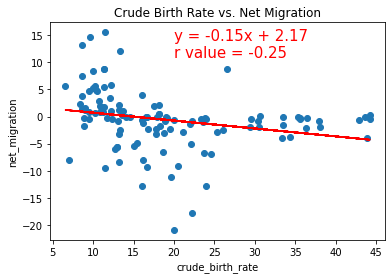

In [54]:
# Per Capita GDP verse net migration
gdp_birth_out = gdp_birth_df.loc[gdp_birth_df['net_migration']>-30]
x_birth = gdp_birth_out['crude_birth_rate']
y_migr = gdp_birth_out['net_migration']
plt.scatter(x_birth,y_migr)
plt.xlabel('crude_birth_rate')
plt.ylabel('net_migration')
plt.title('Crude Birth Rate vs. Net Migration')

# Linear Regression
(slope, intercept, rvalue, pvalue, stderr) = stats.linregress(x_birth, y_migr)
regress_values = x_birth * slope + intercept
plt.plot(x_birth, regress_values, "r-")
reg_str = f"y = {round(slope,2)}x + {round(intercept,2)}"
plt.annotate(reg_str,(20,14),fontsize=15,color="red")
plt.annotate(f"r value = {round(rvalue,2)}",(20,11),fontsize=15,color="red")
plt.savefig("Output/NetMigration-CrudeBirthRate-Regression.png")
plt.show()

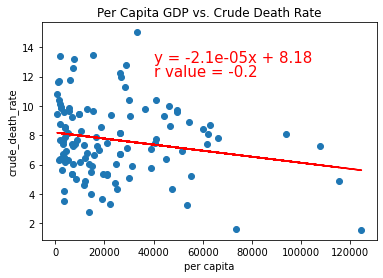

In [55]:
# Per Capita GDP verse crude_death_rate
x_gdp_capita = gdp_birth_df['per capita']
y_death = gdp_birth_df['crude_death_rate']
plt.scatter(x_gdp_capita,y_death)
plt.xlabel('per capita')
plt.ylabel('crude_death_rate')
plt.title('Per Capita GDP vs. Crude Death Rate')

# Linear Regression
(slope, intercept, rvalue, pvalue, stderr) = stats.linregress(x_gdp_capita, y_death)
regress_values = x_gdp * slope + intercept
plt.plot(x_gdp, regress_values, "r-")
reg_str = f"y = {round(slope,6)}x + {round(intercept,2)}"
plt.annotate(reg_str,(40000,13),fontsize=15,color="red")
plt.annotate(f"r value = {round(rvalue,2)}",(40000,12),fontsize=15,color="red")
plt.savefig("Output/CapitaGDP-CrudeDeathRate-Regression.png")
plt.show()

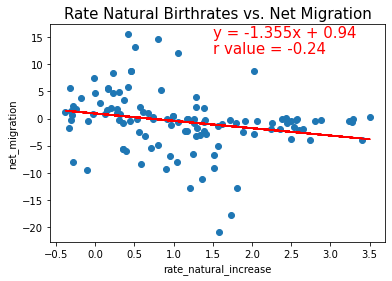

In [56]:
# Per rate_natural_increase verse net migration
x_nat_increase = gdp_birth_df['rate_natural_increase']
y_migr = gdp_birth_df['net_migration']
plt.scatter(x_nat_increase,y_migr)
plt.xlabel('rate_natural_increase')
plt.ylabel('net_migration')
plt.title('Rate Natural Birthrates vs. Net Migration',fontsize=15)

# Linear Regression
(slope, intercept, rvalue, pvalue, stderr) = stats.linregress(x_nat_increase, y_migr)
regress_values = x_nat_increase * slope + intercept
plt.plot(x_nat_increase, regress_values, "r-")
reg_str = f"y = {round(slope,3)}x + {round(intercept,2)}"
plt.annotate(reg_str,(1.5,15),fontsize=15,color="red")
plt.annotate(f"r value = {round(rvalue,2)}",(1.5,12),fontsize=15,color="red")
plt.savefig("Output/NetMigration-RateNaturalIncrease-Regression.png")
plt.show()

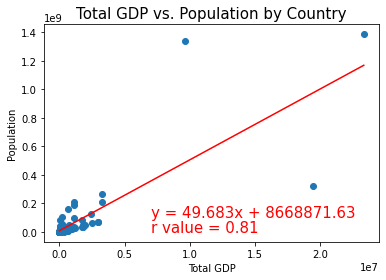

In [57]:
# population verse total GDP
x_gdp = gdp_birth_df['gdp']
y_pop = gdp_birth_df['Population 2017']
plt.scatter(x_gdp,y_pop)
plt.xlabel('Total GDP')
plt.ylabel('Population')
plt.title('Total GDP vs. Population by Country',fontsize=15)

# Linear Regression
(slope, intercept, rvalue, pvalue, stderr) = stats.linregress(x_gdp, y_pop)
regress_values = x_gdp * slope + intercept
plt.plot(x_gdp, regress_values, "r-")
reg_str = f"y = {round(slope,3)}x + {round(intercept,2)}"
plt.annotate(reg_str,(7000000,100000000),fontsize=15,color="red")
plt.annotate(f"r value = {round(rvalue,2)}",(7000000,12),fontsize=15,color="red")
plt.savefig("Output/TotalGDP-Population-Regression.png")
plt.show()

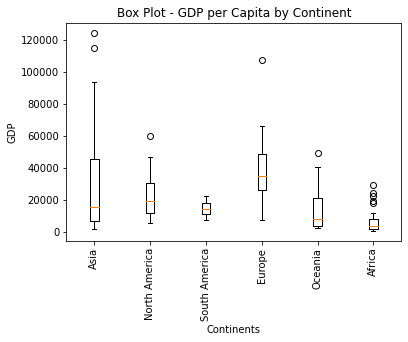

In [68]:
# Generate a box plot continent to review data for outliers
continents = gdp_birth_df['Continent_Name'].unique()

i = 0
for continent in continents:
    gdp = gdp_birth_df.loc[gdp_birth_df['Continent_Name']== continent, 'per capita']  # pandas.core.series.Series
    i = i + 1
    plt.boxplot(gdp, positions = [i])


# set labels of plot
tick_locations = np.arange(1,i+1)
plt.title(f"Box Plot - GDP per Capita by Continent")
plt.xlabel('Continents')
plt.ylabel('GDP')
plt.xticks(tick_locations, continents, rotation="vertical") 
plt.savefig("Output/Box-TotalGDP-Continent.png")
plt.show()

In [59]:
# world heat map for GDP per capita using plotly
fig = px.choropleth(gdp_per_capita, locations='Country Code', 
                        color='per capita',
                        hover_name="country_name", # column to add to hover information
                        color_continuous_scale=px.colors.sequential.Plasma)
fig.show()

In [60]:
# world heat map for GDP using plotly
fig = px.choropleth(gdp_per_capita, locations='Country Code', 
                        color='gdp',
                        hover_name="country_name", # column to add to hover information
                        color_continuous_scale=px.colors.sequential.Plasma)
fig.show()

In [61]:
# world heat map for GDP using plotly
fig = px.choropleth(gdp_per_capita, locations='Country Code', 
                        color='Population 2017',
                        hover_name="country_name", # column to add to hover information
                        color_continuous_scale=px.colors.sequential.Plasma)
fig.show()

In [62]:
# world heat map for net migration using plotly
fig = px.choropleth(net_migration, locations='country_code', 
                        color='net_migration',
                        title=".            Net Migration by Country 2017",
                        hover_name="country_name", # column to add to hover information
                        color_continuous_scale=px.colors.sequential.Plasma)
fig.show()